# <img src="https://github.com/OpenMined/design-assets/raw/master/logos/OM/mark-primary-trans.png" align="center" style="width: 100px;"/> TenSEAL Demo

Welcome to this tutorial, where we will show the core functionality of TenSEAL and some use cases.

If you find it interesting, check out the other tutorials as well:
- ['Tutorial 0 - Getting Started'](./Tutorial%200%20-%20Getting%20Started.ipynb).
- ['Tutorial 1: Training and Evaluation of Logistic Regression on Encrypted Data'](./tutorials/Tutorial%201%20-%20Training%20and%20Evaluation%20of%20Logistic%20Regression%20on%20Encrypted%20Data.ipynb).


## Setup

All modules are imported here. Make sure everything is installed by running the cell below.

In [22]:
import torch
from torchvision import transforms
from random import randint
import pickle
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from typing import Dict

import tenseal as ts

## TenSEAL Context

TenSEAL context is the central component of the library.  It stores the keys and states required by an encrypted computation.

In [23]:
def context():
    context = ts.context(ts.SCHEME_TYPE.CKKS, 8192, coeff_mod_bit_sizes=[60, 40, 40, 60])
    context.global_scale = pow(2, 40)
    context.generate_galois_keys()
    return context

context = context()

### Plain tensor creation

PlainTensor class works as a translation layer from common tensor representations to the encrypted forms offered by TenSEAL.

<img src="assets/plaintensor_indepth.png" align="center" style="display: block;  margin: auto;" />


In [24]:
plain1 = ts.plain_tensor([1,2,3,4], [2,2])
plain1_list = ts.tolist(plain1)
print(" First tensor: Shape = {} Data = {}".format(plain1.shape(), plain1_list))

plain2 = ts.plain_tensor(np.array([5,6,7,8]).reshape(2,2))
plain2_list = ts.tolist(plain2)
print(" Second tensor: Shape = {} Data = {}".format(plain2.shape(), plain2_list))

 First tensor: Shape = [2, 2] Data = [[1.0, 2.0], [3.0, 4.0]]
 Second tensor: Shape = [2, 2] Data = [[5.0, 6.0], [7.0, 8.0]]


### Encrypted tensor creation

The encrypted tensor encrypts a PlainTensor and stores the ciphertexts and shapes internally.

We have a few variants of encrypted tensors:
 - **BFVVector** - for 1d integer arrays.
 - **CKKSVector** - for 1d float arrays.
 - **CKKSTensor** - for n-dimensional float arrays.
 
 
<img src="assets/encrypted_tensor_relation.png" align="center" style="display: block;  margin: auto;" />

In [25]:
encrypted_tensor1 = ts.ckks_tensor(context, plain1)
encrypted_tensor2 = ts.ckks_tensor(context, plain2)

print(" Shape = {}".format(encrypted_tensor1.shape()))
print(" Encrypted Data = {}.".format(encrypted_tensor1.data()))

 Shape = [2, 2]
 Encrypted Data = [<_tenseal_cpp.Ciphertext object at 0x7fc2d0b9ef30>, <_tenseal_cpp.Ciphertext object at 0x7fc2b81ab330>, <_tenseal_cpp.Ciphertext object at 0x7fc2b81ab2b0>, <_tenseal_cpp.Ciphertext object at 0x7fc2b8100a30>].


## Basic operations


| Operation                    | Description                                                   |
| --- | --- |
| negate                       | Negate an encrypted tensor                                    |
| square                       | Compute the square of an encrypted tensor                     |
| power                        | Compute the power of an encrypted tensor                      |
| add                          | Addition between two encrypted tensors                        |
| add\_plain                   | Addition between an encrypted tensor and a plain tensor       |
| sub                          | Subtraction between two encrypted tensors                     |
| sub\_plain                   | Subtraction between an encrypted tensor and a plain tensor    |
| mul                          | Multiplication between two encrypted tensors                  |
| mul\_plain                   | Multiplication between an encrypted tensor and a plain tensor |
| dot\_product                 | Dot product between two encrypted tensors                     |
| dot\_product\_plain          | Dot product between an encrypted tensor and a plain tensor    |
| polyval                      | Polynomial evaluation with an encrypted tensor as variable    |
| matmul\_plain                | Multiplication between an encrypted tensor and a plain matrix |
| enc\_matmul\_plain           | Encrypted matrix multiplication with plain vector             |
| diagonal\_ct\_vector\_matmul | Encrypted\_vector-plain\_matrix multiplication                |
| conv2d\_im2col               | Image Block to Columns                                        |


In [26]:
def decrypt(enc):
    return ts.tolist(enc.decrypt())

### Addition

In [27]:
result = encrypted_tensor1 + encrypted_tensor2
print("Plain equivalent: {} + {}\nDecrypted result: {}.".format(plain1_list, plain2_list, decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] + [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[6.000000001855973, 8.00000000143946], [9.999999997679993, 11.999999999707008]].


### Subtraction

In [28]:
result = encrypted_tensor1 - encrypted_tensor2
print("Plain equivalent: {} - {}\nDecrypted result: {}.".format(plain1_list, plain2_list, decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] - [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[-4.000000002630285, -3.999999998395695], [-4.000000001431845, -4.000000002010512]].


### Multiplication

In [29]:
result = encrypted_tensor1 * encrypted_tensor2
print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1_list, plain2_list, decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[5.000000669194563, 12.000001620396109], [21.00000280090447, 32.000004283904886]].


### Multiplication with plain tensor

In [30]:
plain = ts.plain_tensor([5,6,7,8], [2,2])
result = encrypted_tensor1 * plain

print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1_list, ts.tolist(plain), decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] * [[5.0, 6.0], [7.0, 8.0]]
Decrypted result: [[5.000000668411275, 12.00000161878526], [21.000002803110746, 32.00000428367966]].


### Negation

In [31]:
result = -encrypted_tensor1 

print("Plain equivalent: -{}\nDecrypted result: {}.".format(plain1_list, decrypt(result)))

Plain equivalent: -[[1.0, 2.0], [3.0, 4.0]]
Decrypted result: [[-0.9999999996128438, -2.000000001521883], [-2.999999998124074, -3.9999999988482493]].


### Power

In [32]:
result = encrypted_tensor1 ** 3
print("Plain equivalent: {} ^ 3\nDecrypted result: {}.".format(plain1_list, decrypt(result)))

Plain equivalent: [[1.0, 2.0], [3.0, 4.0]] ^ 3
Decrypted result: [[1.0000008063944623, 8.000006457560826], [27.000021676463525, 64.00005144940928]].


### Polynomial evaluation $1 + X^2 + X^3$

In [33]:
result = encrypted_tensor1.polyval([1,0,1,1])

print("X = {}".format(plain1_list))
print("1 + X^2 + X^3 = {}.".format(decrypt(result)))

X = [[1.0, 2.0], [3.0, 4.0]]
1 + X^2 + X^3 = [[3.0000009395539546, 13.0000069993274], [37.00002287164219, 81.00005358552158]].


### Sigmoid approximation
$\sigma(x) = 0.5 + 0.197 x - 0.004 x^3$

Reference: ["Logistic regression over encrypted data from fully homomorphic encryption", Hao Chen et al](https://eprint.iacr.org/2018/462.pdf)

In [34]:
result = encrypted_tensor1.polyval([0.5, 0.197, 0, -0.004])


print("X = {}".format(plain1_list))
print("0.5 + 0.197 X - 0.004 x^X = {}.".format(decrypt(result)))


X = [[1.0, 2.0], [3.0, 4.0]]
0.5 + 0.197 X - 0.004 x^X = [[0.693000019289264, 0.8620000235410646], [0.9829999925523127, 1.0319998410395388]].


# Encrypted inference demo

The next example contains a classification over the MNIST dataset using a single convolution and two fully connected layers with a square activation function.

It illustrates one of the prominent use cases for homomorphic encryption, as depicted here.

<img src="https://blog.openmined.org/content/images/2020/04/OM---CKKS-Graphic-v.01@2x.png" align="center" style="display: block;  margin: auto;"/>


Adapted from https://github.com/youben11/encrypted-evaluation

## Client Helpers

In [35]:
# Create the TenSEAL security context
def create_ctx():
    poly_mod_degree = 8192
    coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = 2 ** 21
    ctx.generate_galois_keys()
    return ctx

# Sample an image
def load_input():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )
    idx = randint(1, 39)
    img_name = "samples/img_{}.jpg".format(idx)
    img = Image.open(img_name)
    return transform(img).view(28, 28).tolist(), img

# Encode the image
def prepare_input(ctx, plain_input):
    enc_input, windows_nb = ts.im2col_encoding(ctx, plain_input, 7, 7, 3)
    assert windows_nb == 64
    return enc_input

## Server Model

 - We have a pretrained plain model.
 - We adapt the forward call for encrypted inputs.

In [36]:
# Load a pretrained model and adapt the forward call for encrypted input
class ConvMNIST():
    """CNN for classifying MNIST data.
    Input should be an encoded 28x28 matrix representing the image.
    TenSEAL can be used for encoding `tenseal.im2col_encoding(ctx, input_matrix, 7, 7, 3)`
    The input should also be normalized with a mean=0.1307 and an std=0.3081 before encryption.
    """

    def __init__(self, parameters: Dict[str, list]):
        self.conv1_weight = parameters["conv1_weight"]
        self.conv1_bias = parameters["conv1_bias"]
        self.fc1_weight = parameters["fc1_weight"]
        self.fc1_bias = parameters["fc1_bias"]
        self.fc2_weight = parameters["fc2_weight"]
        self.fc2_bias = parameters["fc2_bias"]
        self.windows_nb = parameters["windows_nb"]

    def forward(self, enc_x: ts.CKKSVector) -> ts.CKKSVector:
        # conv layer
        channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, self.windows_nb) + bias
            channels.append(y)
        out = ts.CKKSVector.pack_vectors(channels)
        # squaring
        out.square_()
        # no need to flat
        # fc1 layer
        out.mm_(self.fc1_weight).add_plain_(self.fc1_bias)
        # squaring
        out.square_()
        # output layer
        out.mm_(self.fc2_weight).add_plain_(self.fc2_bias)
        return out

    @staticmethod
    def prepare_input(context: bytes, ckks_vector: bytes) -> ts.CKKSVector:
        try:
            ctx = ts.context_from(context)
            enc_x = ts.ckks_vector_from(ctx, ckks_vector)
        except:
            raise DeserializationError("cannot deserialize context or ckks_vector")
        try:
            _ = ctx.galois_keys()
        except:
            raise InvalidContext("the context doesn't hold galois keys")

        return enc_x
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

## Server helpers

In [37]:
import pickle
import os

def load_parameters(file_path: str) -> dict:
    try:
        parameters = pickle.load(open(file_path, "rb"))
        print(f"Model loaded from '{file_path}'")
    except OSError as ose:
        print("error", ose)
        raise ose
    return parameters



parameters = load_parameters("parameters/ConvMNIST-0.1.pickle")
model = ConvMNIST(parameters)

Model loaded from 'parameters/ConvMNIST-0.1.pickle'


## Client Query

**Steps**:
 - Context creation(only for the first query).
 - Image sampling and encryption.
 - Image and context serialization using **Protobuffers**.

Encrypted image  <_tenseal_cpp.CKKSVector object at 0x7fc349ed61b0>
Original image 


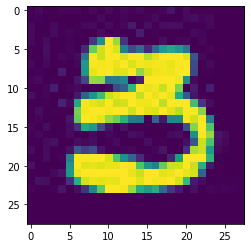

In [38]:
context = create_ctx()
image, orig = load_input()
    
encrypted_image = prepare_input(context, image)

print("Encrypted image ", encrypted_image)
print("Original image ")
imshow(np.asarray(orig))

server_context = context.serialize()
encrypted_image = encrypted_image.serialize()


client_query = {
    "data" : encrypted_image,
    "context" : server_context,
}

## Server inference

**Steps**:
 - Deserialize the context and the encrypted image.
 - Run the inference.
 - Serialize and return the result.

In [39]:
encrypted_query = model.prepare_input(client_query["context"], client_query["data"])
encrypted_result = model(encrypted_query).serialize()

server_response = {
    "data" : encrypted_result
}


## Client process response

Steps:
 - Deserialize the response.
 - Decrypt the response.
 - Apply a softmax and return the label.

In [40]:
result = ts.ckks_vector_from(context, server_response["data"]).decrypt()

probs = torch.softmax(torch.tensor(result), 0)
label_max = torch.argmax(probs)
print("Maximum probability for label {}".format(label_max))


Maximum probability for label 3
